In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

import jax
import jax.numpy as np

import numpy as onp
from numpy.polynomial.hermite import hermgauss

import inspect
import os
import sys
import time

onp.random.seed(3452453)

In [2]:
from bnpmodeling_runjingdev import result_loading_utils

from bnpreg_runjingdev import genomics_data_utils
from bnpreg_runjingdev import regression_mixture_lib
from bnpreg_runjingdev import regression_optimization_lib as reg_optim_lib
from bnpreg_runjingdev import regression_posterior_quantities as reg_posterior_quantities

/accounts/grad/runjing_liu/.conda/envs/bnp_sensitivity_jax/lib/python3.9/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [3]:
import regression_plotting_utils


# Load data

In [4]:
# Set bnp_data_repo to be the location of a clone of the repo
# https://github.com/NelleV/genomic_time_series_bnp
bnp_data_repo = '../../../genomic_time_series_bnp' 

genome_data, timepoints, regressors, beta, beta_infos, y_infos = \
    genomics_data_utils.load_data_and_run_regressions(bnp_data_repo)

Loading data from:  ../../../genomic_time_series_bnp/data/shoemaker2015reprocessed


In [5]:
n_genes = genome_data.shape[0]
reg_dim = regressors.shape[1]

In [6]:
n_timepoints = len(np.unique(timepoints))

### Plot data and predictions 

In red are predictions by the initial regression

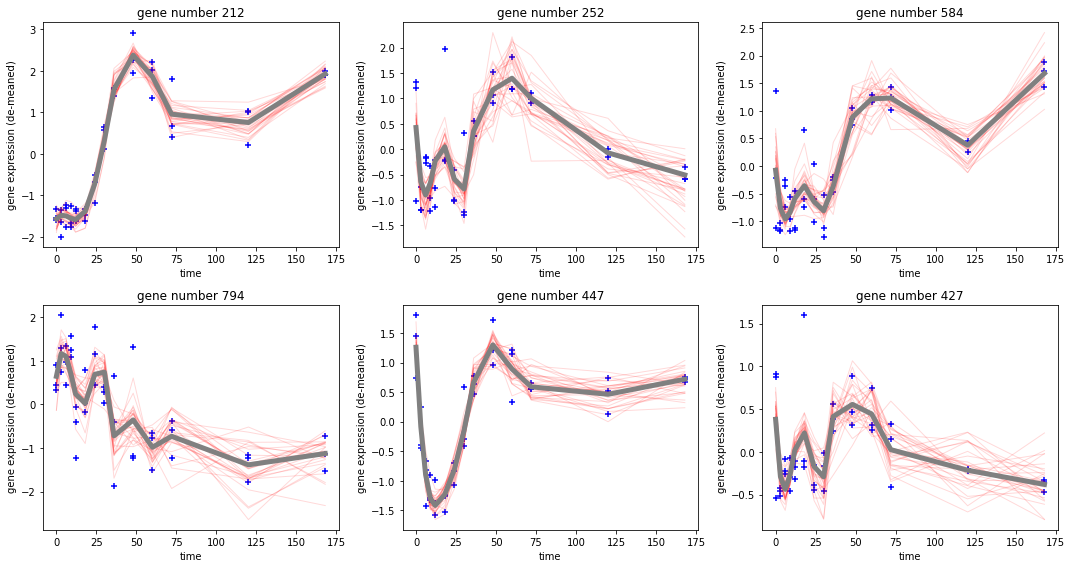

In [7]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

gene_indx = onp.random.choice(n_genes, 6)

for i in range(6):

    n = gene_indx[i]
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    regression_plotting_utils.plot_data(timepoints,
                                        genome_data[n],
                                        this_plot,
                                        demean = True)
    
    regression_plotting_utils.plot_prediction_line_and_sample(timepoints, 
                                                              regressors, 
                                                              beta[n],
                                                              beta_infos[n],
                                                              this_plot)
    
    this_plot.set_title('gene number {}'.format(n))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')


f.tight_layout()

# Prior parameters

In [8]:
prior_params_dict, vb_params_paragami = regression_mixture_lib.get_default_prior_params()

In [9]:
prior_params_dict['dp_prior_alpha'] = 2.0

In [10]:
prior_params_dict

{'dp_prior_alpha': 2.0,
 'prior_centroid_mean': DeviceArray([0.], dtype=float64),
 'prior_centroid_info': DeviceArray([0.1], dtype=float64),
 'prior_shift_mean': DeviceArray([0.], dtype=float64),
 'prior_shift_info': DeviceArray([0.1], dtype=float64),
 'prior_data_info_shape': DeviceArray([10.], dtype=float64),
 'prior_data_info_scale': DeviceArray([0.1], dtype=float64)}

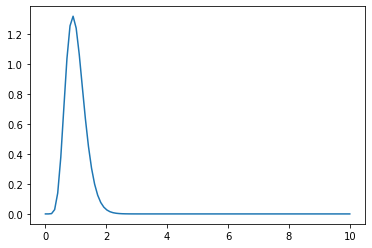

In [11]:
import scipy as osp
x = np.linspace(0, 10, 100)
plt.plot(x, osp.stats.gamma.pdf(x,
                                prior_params_dict['prior_data_info_shape'], 
                                scale = prior_params_dict['prior_data_info_scale']))

# VB parameters

In [12]:
k_approx = 50
vb_params_dict, vb_params_paragami = regression_mixture_lib.get_vb_params_paragami_object(reg_dim, k_approx)

In [13]:
print(vb_params_paragami)

OrderedDict:
	[stick_params] = OrderedDict:
	[stick_means] = NumericArrayPattern (49,) (lb=-inf, ub=inf)
	[stick_infos] = NumericArrayPattern (49,) (lb=0.0001, ub=inf)
	[centroids] = NumericArrayPattern (50, 10) (lb=-inf, ub=inf)
	[data_info] = NumericArrayPattern (1,) (lb=0.0, ub=inf)


### Gauss hermite 

In [14]:
# Gauss-Hermite points for integrating logitnormal stick-breaking prior
gh_deg = 8
gh_loc, gh_weights = hermgauss(gh_deg)

# convert to jax arrays
gh_loc, gh_weights = np.array(gh_loc), np.array(gh_weights)

# Optimize

In [15]:
def get_loss(vb_params_dict): 

    return regression_mixture_lib.get_kl(genome_data, regressors,
                                         vb_params_dict,
                                         prior_params_dict,
                                         gh_loc,
                                         gh_weights)


In [16]:
get_loss(vb_params_dict)

DeviceArray(57112.64849846, dtype=float64)

### K-means init

In [17]:
from copy import deepcopy

In [18]:
vb_params_dict_kmeans = reg_optim_lib.set_params_w_kmeans(genome_data, regressors,
                                                   deepcopy(vb_params_dict),
                                                   vb_params_paragami,
                                                   prior_params_dict, 
                                                   gh_loc, gh_weights)

running initial regressions ...
running k-means ... 
initializing sticks ...


In [19]:
get_loss(vb_params_dict_kmeans)

DeviceArray(9039.67345478, dtype=float64)

### Run newton

In [20]:
vb_opt_dict, vb_opt, ez_opt, out, optim_time = \
    reg_optim_lib.optimize_regression_mixture(genome_data, regressors, 
                                              vb_params_dict_kmeans,
                                              vb_params_paragami,
                                              prior_params_dict, 
                                              gh_loc, 
                                              gh_weights, 
                                              run_newton=True)
print(out.fun)

# vb_opt_dict = vb_params_dict
# vb_opt = vb_params_paragami.flatten(vb_opt_dict, free = True)

compiling objective and derivatives ... 
done. Compile time: 17.051sec
Running L-BFGS-B ...
L-BFGS-B time: 32.991sec
Running trust-ncg ... 
Newton time: 13.606sec
Optimization terminated successfully.
done. 
3839.700506853071


In [21]:
get_loss(vb_opt_dict)

DeviceArray(3839.70050685, dtype=float64)

In [22]:
get_loss(vb_params_dict)

DeviceArray(57112.64849846, dtype=float64)

In [23]:
vb_opt_dict2, vb_opt2, _, _, _ = \
    reg_optim_lib.optimize_regression_mixture(genome_data, regressors, 
                                              vb_params_dict,
                                              vb_params_paragami,
                                              prior_params_dict, 
                                              gh_loc, 
                                              gh_weights, 
                                              run_newton=True)

print(get_loss(vb_opt_dict2))

compiling objective and derivatives ... 
done. Compile time: 16.618sec
Running L-BFGS-B ...
L-BFGS-B time: 55.144sec
Running trust-ncg ... 
Newton time: 18.116sec
Optimization terminated successfully.
done. 
5281.885515285611


In [24]:
get_loss(vb_opt_dict)

DeviceArray(3839.70050685, dtype=float64)

(array([  1.,   1.,   1.,   9., 104., 265.,  97.,  17.,   4.,   1.]),
 array([-14.87945982, -12.13419058,  -9.38892134,  -6.64365209,
         -3.89838285,  -1.15311361,   1.59215564,   4.33742488,
          7.08269413,   9.82796337,  12.57323261]),
 <BarContainer object of 10 artists>)

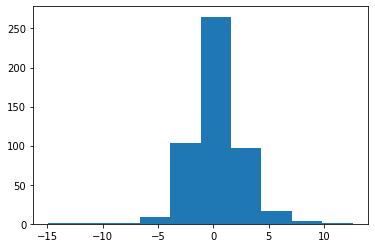

In [48]:
plt.hist(vb_params_dict_kmeans['centroids'].flatten())

In [43]:
np.sqrt(10)

DeviceArray(3.16227766, dtype=float64)

# Check out fit

In [25]:
def get_e_num_obs_per_cluster(vb_params_free): 
    
    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    ez = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data, regressors,
                                                   vb_params_dict,
                                                   prior_params_dict, 
                                                   gh_loc, gh_weights)[0]
    
    return ez.sum(0)

In [26]:
def get_mixture_weights(vb_params_free): 

    vb_params_dict = vb_params_paragami.fold(vb_params_free, free = True)
    
    return reg_posterior_quantities.get_e_mixture_weights_from_vb_dict(vb_params_dict, gh_loc, gh_weights)

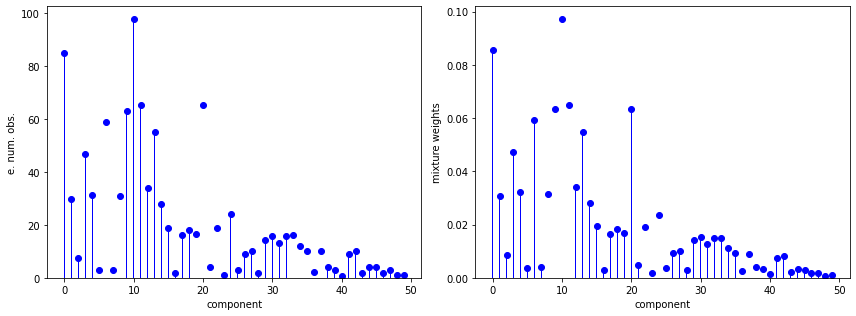

In [27]:
# plot mixture weights and allocations

e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt)
mixture_weights = get_mixture_weights(vb_opt)

fig, axarr = plt.subplots(1, 2, figsize = (12, 4.5))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


In [28]:
vb_opt_dict['data_info']

DeviceArray([3.38288433], dtype=float64)

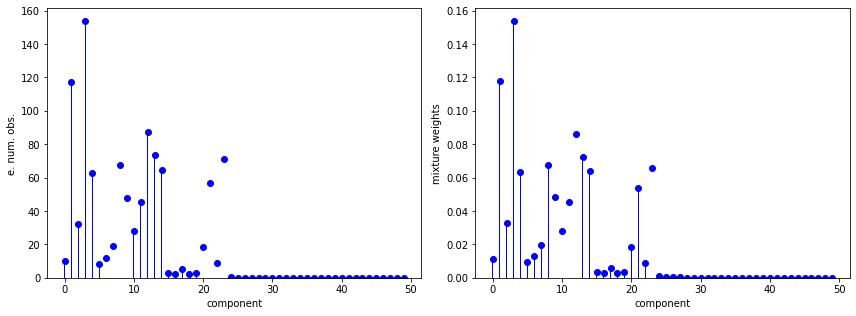

In [29]:
# plot mixture weights and allocations

e_num_obs_per_cluster = get_e_num_obs_per_cluster(vb_opt2)
mixture_weights = get_mixture_weights(vb_opt2)

fig, axarr = plt.subplots(1, 2, figsize = (12, 4.5))

result_loading_utils._plot_weights(e_num_obs_per_cluster, 
                                   axarr[0])

result_loading_utils._plot_weights(mixture_weights, 
                                   axarr[1])


axarr[0].set_ylabel('e. num. obs.')
axarr[1].set_ylabel('mixture weights')
    
fig.tight_layout()


In [30]:
from bnpmodeling_runjingdev import exponential_families as ef

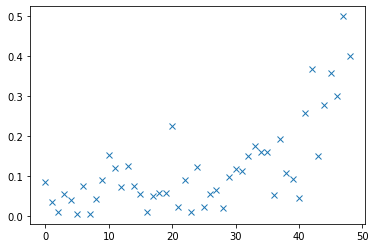

In [31]:
stick_means = ef.get_e_logitnormal(vb_opt_dict['stick_params']['stick_means'],
                              vb_opt_dict['stick_params']['stick_infos'],
                              gh_loc, gh_weights)

plt.plot(stick_means, 'x')

(array([  2.,  21.,  14.,  16.,  21.,  15.,  33.,  44.,  63., 771.]),
 array([0.44245696, 0.49821127, 0.55396557, 0.60971987, 0.66547418,
        0.72122848, 0.77698278, 0.83273709, 0.88849139, 0.9442457 ,
        1.        ]),
 <BarContainer object of 10 artists>)

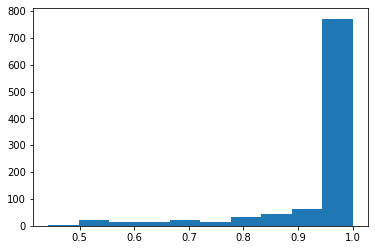

In [32]:
plt.hist(ez_opt.max(1))

In [33]:
len(np.unique(ez_opt.argmax(1)))

50

# Plot top centroids

In [34]:
top_clusters_sorted = np.argsort(-e_num_obs_per_cluster)

In [35]:
est_centroids = vb_opt_dict['centroids']

In [36]:
est_shifts = reg_posterior_quantities.get_optimal_local_params_from_vb_dict(genome_data,
                                                                            regressors,
                                                                            vb_opt_dict,
                                                                            prior_params_dict, 
                                                                            gh_loc, gh_weights)[2]

In [37]:
mean_operator = onp.zeros((genome_data.shape[1], n_timepoints))
for i in range(n_timepoints): 
    mean_operator[3*i:((i+1)*3), i] = 1/3

In [38]:
unique_timepoints = np.unique(timepoints)
_y = np.dot(genome_data, mean_operator)

TypeError: len() of unsized object

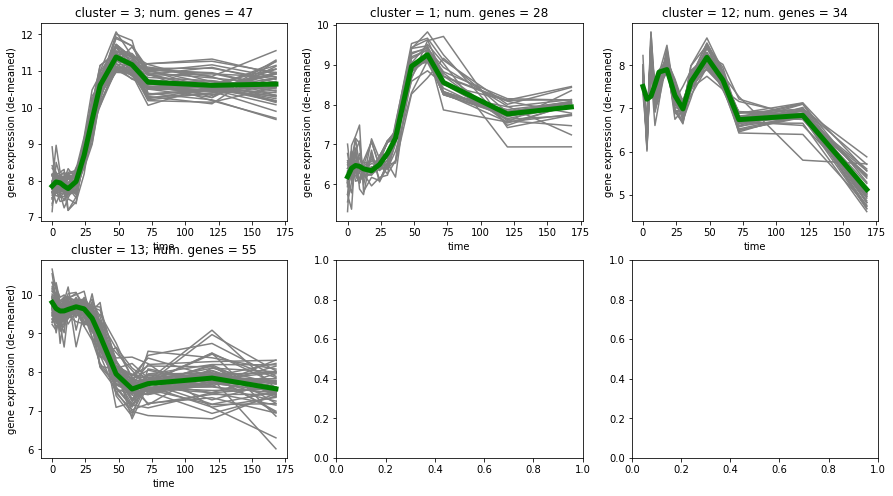

In [39]:
f, axarr = plt.subplots(2, 3, figsize=(15,8))

for i in range(6):
    which_cluster = top_clusters_sorted[i]
    which_genes = np.argwhere(ez_opt.argmax(1) == which_cluster).squeeze()
    
    this_plot = axarr[int(np.floor(i / 3)), i % 3]
    
    this_plot.set_title('cluster = {}; num. genes = {}'.format(which_cluster, len(which_genes)))
    this_plot.set_xlabel('time')
    this_plot.set_ylabel('gene expression (de-meaned)')

    # Plot genes in this cluster
    for n in which_genes: 
        this_plot.plot(unique_timepoints, _y[n] - est_shifts[n, which_cluster],
                       color = 'grey')
        
    # plot centroid
    regression_plotting_utils.plot_prediction_line(timepoints, 
                                                   regressors, 
                                                   est_centroids[which_cluster], 
                                                   ax = this_plot, 
                                                   linewidth = 5, 
                                                   color = 'green')
    

f.tight_layout()
